In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow, legend, show, figure
import cv2

print(tf.config.list_physical_devices('GPU'))
print(tf.debugging.set_log_device_placement(True))
print(tf.test.is_built_with_cuda())

tf.compat.v1.disable_v2_behavior()
tf.version.VERSION

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
True
Instructions for updating:
non-resource variables are not supported in the long term


'2.4.1'

In [2]:
BATCH_SIZE = 20

In [3]:
# !pip install tensorflow==2.3.2
# !pip install tensorflow-gpu==2.3.2
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# from matplotlib.pyplot import imshow, legend, show, figure

# print(tf.config.list_physical_devices('GPU'))
# print(tf.debugging.set_log_device_placement(True))
# print(tf.test.is_built_with_cuda())

# tf.compat.v1.disable_v2_behavior()
# tf.version.VERSION

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
lesions = {0: "Basal Cell Carcinoma", 
    1: "Lentigo",
    2: "Malignant Melanoma", 
    3: "Melanocytic naevus",
    4: "seborrhoeic keratosis",
    5: "Wart", 
    6: "Actinic Keratosis",
    7: "Squamous Cell Carcinoma",
    8: "Intraepithelial Carcinoma", 
    9: "Pyogenic Granuloma",
    10: "Haemangioma",
    11: "Dermatofibroma"
}

In [6]:
def preprocessing(img):
    image = tf.keras.preprocessing.image.img_to_array(img)
#     print(image.dtype)
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)
#     print(image.dtype)
#     image = image / .8
#     standarlized_image = (image-np.mean(image))/np.std(image)
    image = tf.keras.applications.resnet.preprocess_input(image)
    normalized_image = (image - image.min())/(image.max() - image.min())
    
#     standarlized_image = (image-np.mean(image))/np.std(image)
    return normalized_image

In [7]:
src_path_train = "dataset-split/train/"

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(
    directory=src_path_train,
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    target_size=(224, 224),
    shuffle=True,
    seed=42
)

Found 59850 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


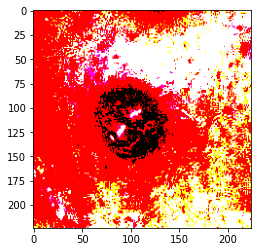

In [8]:
imgs, labels = next(train_generator)

imshow(cv2.cvtColor(imgs[3], cv2.COLOR_BGR2RGB))

In [9]:
train_generator.samples

59850

In [10]:
src_path_val = "dataset-split/val/"

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(
    directory=src_path_val,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=42
)

Found 6570 images belonging to 12 classes.


In [11]:
# src_path_test = "dataset-split/test/"
# test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing).flow_from_directory(
#     directory=src_path_test,
#     target_size=(224, 224),
#     color_mode="rgb",
#     batch_size=1,
#     class_mode=None,
#     shuffle=False,
#     seed=42
# )

In [12]:
# imgs, labels = next(train_generator)

# imshow(imgs[13])

In [13]:
import tensorflow_addons as tfa

lr = 0.01
eps = 10e-3
epochs = 10
momentum = 0.9
wd = 1e-05
gamma = 0.1
ds = train_generator.samples / BATCH_SIZE
number_of_train_images = train_generator.classes.shape[0]
steps_per_epoch = number_of_train_images/BATCH_SIZE

conv_base = tf.keras.applications.ResNet152(weights='imagenet', include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

model = tf.keras.models.Sequential()
model.add(conv_base)

# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))
# model.add(tf.keras.layers.Dense(units = 256, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(12, activation=tfa.activations.sparsemax, name='predictions'))
model.add(tf.keras.layers.Dense(units = 12, activation='softmax', name='predictions'))

# from keras_lr_finder import LRFinder

# model.add(tf.keras.layers.AveragePooling2D((7, 7), name='avg_pool'))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(12, activation='softmax', name='predictions'))

# lr_scheduling = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=lr, decay_steps=ds, decay_rate=dr
# )

lr_scheduling = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr, decay_steps=ds, decay_rate=gamma, staircase=True
)


# opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
opt = tfa.optimizers.SGDW(learning_rate=lr_scheduling, momentum=momentum, weight_decay=wd)

# loss = tf.keras.losses.sparse_categorical_crossentropy(
#     y_true= , y_pred, from_logits=False, axis=-1
# )

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_top_k_categorical_accuracy', tfa.metrics.MultiLabelConfusionMatrix(num_classes=12)])

model.summary()

# lr_finder = LRFinder(model)
# lr_finder.find(imgs, labels, 0.0001, 0.01, 16, 10)
# lr_finder.plot_loss()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 12)                24588     
Total params: 58,395,532
Trainable params: 24,588
Non-trainable params: 58,370,944
_________________________________________________________________


In [15]:
print(model.evaluate(train_generator))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[3.5933909410622618, 0.062088553, 0.37059316, array([[[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]],

       [[41310.,     0.],
        [58950.,     0.]]], dtype=float32)]


In [ ]:

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=epochs, steps_per_epoch = steps_per_epoch)

In [ ]:
# model.save('./model/lesions-resnet152-model')


In [ ]:
try:
    import shap
except Exception as error:
    !pip install {str(error)[17:-1]}
    import shap
except:
    print("Pacote não encontrado")

In [ ]:
from PIL import Image
from numpy import asarray
import pandas as pd
import random
test = pd.read_csv('test.csv',index_col=0)
train = pd.read_csv('train.csv',index_col=0)
df_test = pd.DataFrame(test)
test_dataset_filenames = df_test['id'].values.tolist()
test_dataset_filenames_background = np.random.choice(test_dataset_filenames, 10, replace=False)
test_dataset_filenames = np.random.choice(test_dataset_filenames, 5, replace=False)

numpy_images = []
for image in test_dataset_filenames:
    image = Image.open(image)
    image = asarray(image)
    image = tf.keras.applications.resnet.preprocess_input(image)
    numpy_images.append(image)
    
background = []
for image in test_dataset_filenames_background:
    image = Image.open(image)
    image = asarray(image)
    image = image.astype(np.float32)
    image /= 255
    background.append(image)
    
x_pixel_values = []
for image in test_dataset_filenames:
    image = Image.open(image)
    image = asarray(image)
    image = image.astype(np.float32)
    image /= 255
    x_pixel_values.append(image)

background = asarray(background)
x = asarray(numpy_images)
x_pixel_values = asarray(x_pixel_values)
imshow(x_pixel_values[0])

In [ ]:
imshow(x[0])

In [ ]:
print(x.shape[0])


# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


In [ ]:
shap_values = e.shap_values(x)

In [ ]:
shap.image_plot(shap_values, x_pixel_values)

In [ ]:
model.summary()

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
No_Of_Epochs = range(epochs)
# No_Of_Epochs = range(1)

plt.plot(No_Of_Epochs, train_acc, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Training Accuracy and Testing Accuracy w.r.t Number of Epochs')

plt.legend()

plt.figure()

plt.plot(No_Of_Epochs, train_loss, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')

plt.title('Training Loss and Testing Loss w.r.t Number of Epochs')

plt.legend()

plt.show()

In [ ]:
predictions = model.predict(x)
classes = np.argmax(predictions, axis = 1)
print(classes)